- ### Planteamiento del problema:

Encontrar si existe relación entre los recursos sanitarios y los datos sociodemográficos.

In [139]:
# Se importa el dataset
import pandas as pd

url = 'https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv'
dataframe = pd.read_csv(url)

- ### Exploración y limpieza de datos:

In [140]:
# Primera apreciacion del dataset
filas = dataframe.shape[0]
columnas = dataframe.shape[1]
print(f'Filas: {filas} | Columnas: {columnas}')
print()
print(dataframe.info())

Filas: 3140 | Columnas: 108

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB
None


In [141]:
nulos = dataframe.isnull().sum()
if len(nulos[nulos != 0]) == 0:

    print('No hay datos nulos')

else:

    print(nulos[nulos != 0])

No hay datos nulos


In [142]:
columnas = dataframe.columns.tolist()

for i in columnas:

    print(i)

fips
TOT_POP
0-9
0-9 y/o % of total pop
19-Oct
10-19 y/o % of total pop
20-29
20-29 y/o % of total pop
30-39
30-39 y/o % of total pop
40-49
40-49 y/o % of total pop
50-59
50-59 y/o % of total pop
60-69
60-69 y/o % of total pop
70-79
70-79 y/o % of total pop
80+
80+ y/o % of total pop
White-alone pop
% White-alone
Black-alone pop
% Black-alone
Native American/American Indian-alone pop
% NA/AI-alone
Asian-alone pop
% Asian-alone
Hawaiian/Pacific Islander-alone pop
% Hawaiian/PI-alone
Two or more races pop
% Two or more races
POP_ESTIMATE_2018
N_POP_CHG_2018
GQ_ESTIMATES_2018
R_birth_2018
R_death_2018
R_NATURAL_INC_2018
R_INTERNATIONAL_MIG_2018
R_DOMESTIC_MIG_2018
R_NET_MIG_2018
Less than a high school diploma 2014-18
High school diploma only 2014-18
Some college or associate's degree 2014-18
Bachelor's degree or higher 2014-18
Percent of adults with less than a high school diploma 2014-18
Percent of adults with a high school diploma only 2014-18
Percent of adults completing some college 

In [143]:
dataframe.dtypes.value_counts()

float64    61
int64      45
object      2
Name: count, dtype: int64

In [144]:
dataframe.columns[dataframe.dtypes == 'object']

Index(['COUNTY_NAME', 'STATE_NAME'], dtype='object')

- Inicialmente se puede observar que no existen valores nulos en ninguna de las variables.
- Hay 3.140 registros y 108 variables incluyendo la variable objetivo.
- Hay 2 variables categóricas y 106 numéricas.
- Se establece la variable objetivo a "Obesity_number", pues se relaciona con la salud de la población.

In [145]:
# Se verifica la existencia de duplicados
duplicados = dataframe.duplicated().sum()
print(f'Existen {duplicados} registros duplicados.')
print(f'El % de registros "duplicados" es {duplicados/filas}.')

Existen 0 registros duplicados.
El % de registros "duplicados" es 0.0.


No Existen datos duplicados en el dataframe.

- #### Se pretende hallar las variables de mayor relevancia para continuar con el análisis.

Ya que únicamente hay 2 variables categóricas, y además sólo representan el nombre del condado y del estado, no se tomarán en cuenta en el escalado de variables numéricas, ya que existen muchas más variables sociodemográficas que permitan un análisis más profundo.

In [146]:
dataframe.drop(dataframe.select_dtypes(include = ['object']).columns, axis =1, inplace = True)

In [147]:
# Escalado o normalizacion de las variables.

#Primero se separan los conjuntos de train y test
from sklearn.model_selection import train_test_split

X = dataframe.drop(['Obesity_number'], axis = 1)
y = dataframe['Obesity_number']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [148]:
n_columns = X.columns.tolist()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_train = pd.DataFrame(X_train_scaled, index = X_train.index, columns = n_columns)

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, index = X_test.index, columns = n_columns)

In [149]:
# Seleccionar las variables más relevantes
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_regression, SelectKBest

k = int(len(X_train.columns)*0.15)

selection_model = SelectKBest(f_regression, k = k)
selection_model.fit(X_train, y_train)
ix = selection_model.get_support()
X_train = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

print(X_train.columns)

Index(['TOT_POP', '0-9', '19-Oct', '40-49', 'POP_ESTIMATE_2018',
       'High school diploma only 2014-18',
       'Some college or associate's degree 2014-18',
       'Civilian_labor_force_2018', 'Total Population',
       'county_pop2018_18 and older', 'anycondition_number',
       'Heart disease_number', 'COPD_number', 'diabetes_number', 'CKD_number'],
      dtype='object')


- ### Análisis Numérico-Numérico completo:

In [ ]:
#Normalizacion de las variables categóricas
dataframe["sex"] = pd.factorize(dataframe["sex"])[0]
dataframe["smoker"] = pd.factorize(dataframe["smoker"])[0]
dataframe["region"] = pd.factorize(dataframe["region"])[0]

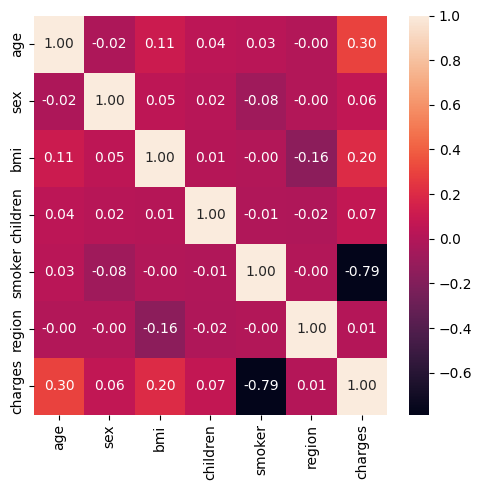

In [ ]:
plt.figure(figsize = (5,5))

sns.heatmap(dataframe[['age', 'sex', 'bmi', 'children', 'smoker', 'region',
                       'charges']].corr(), annot = True, fmt = ".2f", annot_kws={'size': 10})

plt.tight_layout()
plt.show()

- No hay correlación importante entre las variables independientes, por lo cual no existen problemas de multicolinealidad.
- Como ya se había visto anteriormente, existe una relación inversa e importante entre población fumadora y el precio de la póliza, es decir, población fumadora se incrementan los precios.
- La región, el sexo y la cantidad de hijos no tienen una relación lineal relevante con la variable dependiente. Por lo cual no se tomarán en cuenta para el entrenamiento del modelo.


Se escalan los datos con StandardScaler este método es menos sensible a los outliers, no se eliminan outliers, se desea esperar el rendimiento del modelo y en dado caso se podrian usar métodos de regularización antes de tratar esos datos.

In [ ]:
dataframe.drop(['region','children','sex'], axis = 1, inplace = True)
print(dataframe.head(2))

   age    bmi  smoker     charges
0   19  27.90       0  16884.9240
1   18  33.77       1   1725.5523


- ### Escalado/Normalizacion

In [ ]:
#Primero se separan los conjuntos de train y test
from sklearn.model_selection import train_test_split

X = dataframe.drop(['charges'], axis = 1)
y = dataframe['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
n_columns = X.columns.tolist()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_train = pd.DataFrame(X_train_scaled, index = X_train.index, columns = n_columns)

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, index = X_test.index, columns = n_columns)

In [ ]:
print(X_train.head(2))

           age       bmi    smoker
1114 -1.157680 -0.996928  0.500292
968  -1.300619 -0.792762  0.500292


#### Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_predict = model.predict(X_test)

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

print(f"Mean squared error: {mean_squared_error(y_test, y_predict)}")
print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_predict))}')
print(f"Coefficient of determination: {r2_score(y_test, y_predict)}")

Mean squared error: 35841574.8181475
RMSE:5986.783344847841
Coefficient of determination: 0.8049502474643173


Este tipo de modelo no cuenta con hiperparámetros para optimizar.